# VQA model accuracy

In [1]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
import pandas as pd
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import json
import matplotlib.pyplot as plt
from PIL import Image
import time
import re, sys
import os
import copy
import shutil
import io
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

%matplotlib inline

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

PyTorch Version:  1.13.1+cu117
Torchvision Version:  0.14.1+cu117
cuda:0


**Load VizWiz test set data** (with PromptCap model output)

In [2]:
with open('/media/arnau/SSD/VizWiz/models/hf_model_test_res.json', encoding='UTF-8') as jf:
    model_output_data = json.load(jf)

**Load VizWiz test set data** (with extra models output)

In [3]:
with open('/media/arnau/SSD/VizWiz/models/hf_extra_models_test_res.json', encoding='UTF-8') as jf:
    other_models_output_data = json.load(jf)

# Add GT answers
for img_name, data in other_models_output_data.items():
    other_models_output_data[img_name]["gt_answers"] = model_output_data[img_name]["gt_answers"]

In [4]:
val_imgs = os.listdir('/media/arnau/SSD/VizWiz/data/captioning/val/')
test_imgs = list(model_output_data.keys())
test_fin_imgs = [img for img in test_imgs if img in val_imgs]

if os.path.exists("/media/arnau/SSD/VizWiz/data/test_imgs/") == False:
    os.mkdir("/media/arnau/SSD/VizWiz/data/test_imgs/")
    
    # Copy test images to separate folder
    for img in test_fin_imgs:
        original = f'/media/arnau/SSD/VizWiz/data/captioning/val/{img}'
        target = f"/media/arnau/SSD/VizWiz/data/test_imgs/{img}"
        shutil.copyfile(original, target)

In [5]:
get_model_types = lambda d : [el 
                               for el in list(d[next(iter(d))].keys()) 
                               if el not in ['question', 'gt_answers']]

Merge both dictionaries into a single one

In [6]:
merged = model_output_data.copy()

for typ in get_model_types(other_models_output_data):
    for img_name, data in merged.items():
        try:
            other_model_result = other_models_output_data[img_name][typ]
            merged[img_name][typ] = other_model_result
        except:
            pass
        
model_output_data = merged

Show all models 

In [7]:
get_model_types(model_output_data)

['HF_OCR_google_answer',
 'HF_OCR_answer',
 'HF_NON_OCR_answer',
 'ViLT',
 'SF_LAVIS',
 'BLIP2-VQA',
 'BLIP2-CTX-VQA']

## Models accuracy
Various VQA models evaluated on VizWiz test set

### Helper functions

In [8]:
def remove_periods(q):
    
    outText = q
    puncts = [';', r"/", '[', ']', '"', '{', '}',
                                 '(', ')', '=', '+', '\\', '_', '-',
                                 '>', '<', '@', '`', ',', '?', '!']
    comma_strip = re.compile("(\d)(\,)(\d)")
    periodStrip  = re.compile("(?!<=\d)(\.)(?!\d)")
    for p in puncts:
        if (p + ' ' in q or ' ' + p in q) or (re.search(comma_strip, q) != None):
            outText = outText.replace(p, '')
        else:
            outText = outText.replace(p, ' ')
            outText = periodStrip.sub("",
                                           outText,
                                           re.UNICODE)
    return outText

In [9]:


def num_words_to_digit(q):
    
    outText = []
    tempText = q.lower().split()
    manualMap  = { 'none': '0',
                    'zero': '0',
                    'one': '1',
                     'two': '2',
                     'three': '3',
                     'four': '4',
                     'five': '5',
                     'six': '6',
                     'seven': '7',
                     'eight': '8',
                     'nine': '9',
                     'ten': '10'}
    articles     = ['a',
                             'an',
                             'the'
                    ]
    contractions = {"aint": "ain't", "arent": "aren't", "cant": "can't", "couldve": "could've", "couldnt": "couldn't", \
                            "couldn'tve": "couldn't've", "couldnt've": "couldn't've", "didnt": "didn't", "doesnt": "doesn't", "dont": "don't", "hadnt": "hadn't", \
                            "hadnt've": "hadn't've", "hadn'tve": "hadn't've", "hasnt": "hasn't", "havent": "haven't", "hed": "he'd", "hed've": "he'd've", \
                            "he'dve": "he'd've", "hes": "he's", "howd": "how'd", "howll": "how'll", "hows": "how's", "Id've": "I'd've", "I'dve": "I'd've", \
                            "Im": "I'm", "Ive": "I've", "isnt": "isn't", "itd": "it'd", "itd've": "it'd've", "it'dve": "it'd've", "itll": "it'll", "let's": "let's", \
                            "maam": "ma'am", "mightnt": "mightn't", "mightnt've": "mightn't've", "mightn'tve": "mightn't've", "mightve": "might've", \
                            "mustnt": "mustn't", "mustve": "must've", "neednt": "needn't", "notve": "not've", "oclock": "o'clock", "oughtnt": "oughtn't", \
                            "ow's'at": "'ow's'at", "'ows'at": "'ow's'at", "'ow'sat": "'ow's'at", "shant": "shan't", "shed've": "she'd've", "she'dve": "she'd've", \
                            "she's": "she's", "shouldve": "should've", "shouldnt": "shouldn't", "shouldnt've": "shouldn't've", "shouldn'tve": "shouldn't've", \
                            "somebody'd": "somebodyd", "somebodyd've": "somebody'd've", "somebody'dve": "somebody'd've", "somebodyll": "somebody'll", \
                            "somebodys": "somebody's", "someoned": "someone'd", "someoned've": "someone'd've", "someone'dve": "someone'd've", \
                            "someonell": "someone'll", "someones": "someone's", "somethingd": "something'd", "somethingd've": "something'd've", \
                            "something'dve": "something'd've", "somethingll": "something'll", "thats": "that's", "thered": "there'd", "thered've": "there'd've", \
                            "there'dve": "there'd've", "therere": "there're", "theres": "there's", "theyd": "they'd", "theyd've": "they'd've", \
                            "they'dve": "they'd've", "theyll": "they'll", "theyre": "they're", "theyve": "they've", "twas": "'twas", "wasnt": "wasn't", \
                            "wed've": "we'd've", "we'dve": "we'd've", "weve": "we've", "werent": "weren't", "whatll": "what'll", "whatre": "what're", \
                            "whats": "what's", "whatve": "what've", "whens": "when's", "whered": "where'd", "wheres": "where's", "whereve": "where've", \
                            "whod": "who'd", "whod've": "who'd've", "who'dve": "who'd've", "wholl": "who'll", "whos": "who's", "whove": "who've", "whyll": "why'll", \
                            "whyre": "why're", "whys": "why's", "wont": "won't", "wouldve": "would've", "wouldnt": "wouldn't", "wouldnt've": "wouldn't've", \
                            "wouldn'tve": "wouldn't've", "yall": "y'all", "yall'll": "y'all'll", "y'allll": "y'all'll", "yall'd've": "y'all'd've", \
                            "y'alld've": "y'all'd've", "y'all'dve": "y'all'd've", "youd": "you'd", "youd've": "you'd've", "you'dve": "you'd've", \
                            "youll": "you'll", "youre": "you're", "youve": "you've"
                            }
    for word in tempText:
        word = manualMap.setdefault(word, word)
        if word not in articles:
            outText.append(word)
        else:
            pass

    for wordId, word in enumerate(outText):
        if word in contractions:
            outText[wordId] = contractions[word]
    outText = ' '.join(outText)
    return outText

In [10]:
def updateProgress(progress):
    
    barLength = 20
    status = ""
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
        status = "error: progress var must be float\r\n"
    if progress < 0:
        progress = 0
        status = "Halt...\r\n"
    if progress >= 1:
        progress = 1
        status = "Done...\r\n"
    block = int(round(barLength*progress))
    text = "\rFinshed Percent: [{0}] {1}% {2}".format( "#"*block + "-"*(barLength-block), int(progress*100), status)
    sys.stdout.write(text)
    sys.stdout.flush()

### Evaluation

In [11]:
def evaluate_acc_promptcap(model_output_data, model_type):
    """ 
    Calculates accuracy metric for VQA model
    """
    
    accQA       = []
    step = 0
    
    data = model_output_data.copy()
    
    for img, img_info in data.items():
        question = img_info["question"]
        gtanswers = img_info["gt_answers"]
        for ans in gtanswers:
            if type(ans['answer']) == str:
                ans['answer'] = ans['answer'].replace('\n', ' ').replace('\t', ' ').strip().lower()
            else:
                ans['answer'] = ' '.join(ans['answer'])
        try:
            resAns = img_info[model_type]
            resAns = resAns.replace('\n', ' ')
            resAns = resAns.replace('\t', ' ')
            resAns = resAns.strip()
            resAns = resAns.lower()
        except:
            resAns = ''
        gtAcc = []
        gtAnswers = [ans["answer"] for ans in gtanswers]

        if len(set(gtAnswers)) > 1:
            for ans in gtanswers:
                if type(ans['answer']) == str:
                    ans["answer"] = remove_periods(ans['answer'])
                    ans["answer"] = num_words_to_digit(ans['answer'])
                else:
                    ans["answer"] = remove_periods(' '.join(ans['answer']))
                    ans["answer"] = num_words_to_digit(' '.join(ans['answer']))
            resAns = remove_periods(resAns)
            resAns = num_words_to_digit(resAns)

        for ans in gtanswers:
            # otherGTAns = [item for item in gtanswers if item!=ans]
            matchingAns = [ans for ans in gtanswers if ans['answer'] == resAns]
            acc = min(1, float(len(matchingAns))/3)
            gtAcc.append(acc)

        avgGTAcc = float(sum(gtAcc))/len(gtAcc)
        accQA.append(avgGTAcc)

        if step%100 == 0:
            updateProgress(step/float(len(data.keys())))
        step = step + 1
    
    return accQA


In [12]:
import cv2
import numpy as np

img_list = list(model_output_data.keys())
np.random.shuffle(img_list)
img_list = img_list[:25]

resized_images = []

# Resize the images to a consistent shape
target_shape = (300, 300)  # Set your desired target shape here

image_path = '/media/arnau/SSD/VizWiz/data/captioning/val/'

for img_name in img_list:
    image = cv2.imread(image_path + img_name)
    resized_image = cv2.resize(image, target_shape)
    resized_images.append(resized_image)

# Convert the resized_images list to a NumPy array
image_array = np.array(resized_images)

# Calculate the mean
mean = np.mean(image_array, axis=(0, 1, 2)) / 255.0

# Calculate the standard deviation
std = np.std(image_array, axis=(0, 1, 2)) / 255.0

print("Mean:", mean)
print("Standard Deviation:", std)


Mean: [0.37228625 0.41638059 0.46563346]
Standard Deviation: [0.27782804 0.27666213 0.29458398]


In [13]:
default_results = []

for typ in get_model_types(model_output_data)[:-1]:
    res = evaluate_acc_promptcap(model_output_data, typ)
    acc = (sum(res) / len(res)) * 100
    default_results.append((typ, acc))
    print(f"--> {typ}: {acc:.4f}%")

Finshed Percent: [###################-] 93% --> HF_OCR_google_answer: 8.6062%
Finshed Percent: [###################-] 93% --> HF_OCR_answer: 7.0159%
Finshed Percent: [###################-] 93% --> HF_NON_OCR_answer: 10.6330%
Finshed Percent: [###################-] 93% --> ViLT: 9.5104%
Finshed Percent: [###################-] 93% --> SF_LAVIS: 15.8403%
Finshed Percent: [###################-] 93% --> BLIP2-VQA: 17.2123%


## Models accuracy using filtering models

Models accuracy evaluted on VizWiz test set with a prior filtering of blurred images using a custom blur detection model

In [14]:
import torch.nn.functional as F

def model_inference(img, model_params, multiclass=None):
    """
    Returns 1 if the input image is blurred otherwise returns 0
    """
    
    model, device, thr = model_params

    trnsfm = {
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.33011644, 0.40721696, 0.51554057], 
                             std=[0.26439891, 0.26886196, 0.27917049])
    ])
    }

    model.eval()

    if type(img) == str:
        test_path = '/media/arnau/SSD/VizWiz/data/captioning/val/'
        img_path = os.path.join(test_path, img)
        img = Image.open(img_path)

    img = trnsfm["val"](img)
    img = img[None, :, :, :] 
    img = img.to(device)
    outputs = model(img)

    if not multiclass:
        pred = torch.sigmoid(outputs.data).cpu().detach().numpy().tolist()[0][0]
        pred_res = 1 if float(pred) > float(thr) else 0
    else:
        pred = F.softmax(outputs.data).cpu().detach().numpy()[0][0] # value of class0 (clear)
        pred_res = 0 if float(pred) > float(thr) else 1
        #pred_res = torch.argmax(outputs.data, 1).cpu().detach().numpy()[0]

    return pred_res


In [15]:
def initialize_model(model_path, num_classes):
    """
    Initializes the blur model
    """
    
    # GPU device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    model = models.convnext_tiny(weights='IMAGENET1K_V1')

    num_ftrs = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(num_ftrs, num_classes)
    
    # Load custom blur model
    model.load_state_dict(torch.load(model_path))
    model = model.to(device)
    
    return model

In [16]:
def get_clear_images(model_output_data, model_params, multiclass):
    """
    Given a dataset of images, returns a filtered array where the blurred images
    have been removed
    """
    
    clear_images = {}
    
    for img, img_info in model_output_data.items():
        # Flaw model filter with %
        flaw_detection = model_inference(img, model_params, multiclass) # Returns 1 if img is blur otherwise 0
        if flaw_detection == 0:
            clear_images[img] = img_info
            
    return clear_images
 
    
def percent_imgs_rejected(og_data, filt_data):
    #imgs_rejected = len(og_data.keys()) - len(filt_data.keys())
    
    #if len(filt_data.keys()) == 0:
        #p_imgs_rejected = 0.0
        
    #p_imgs_rejected = (imgs_rejected / len(og_data.keys())) * 100
    
    p_imgs_rejected =  100. - 100. * len(filt_data.keys()) / len(og_data.keys())
    
    return p_imgs_rejected

    

In [17]:
model_path = '../outputs/best_FRM_convnext.pth'
flaw = model_path.split("_")[1]
num_classes = 1 if flaw in ["BLR", "FRM"] else 4

multiclass = True if num_classes > 1 else False
model = initialize_model(model_path, num_classes, )

model_params = (model, device)

In [18]:
data = {"model_type": [],
        "thr": [], 
        "p_imgs_rej": [],
      "acc": []}

# Remap models naming
map_type = { "HF_OCR_google_answer" : "PromptCap + GoogleOCR",
                "HF_OCR_answer" : "PromptCap + EasyOCR",
                "HF_NON_OCR_answer": "PromptCap",
            "SF_LAVIS" : "BLIP-VQA"
           }

In [19]:
blur_results = []
rej_rates = np.flip(np.arange(0., 1.1, 0.1), 0)

# For every rejection rate, compares the default model (rej_rates = 0.0) with 
for rr in rej_rates:
    filtered_data = get_clear_images(model_output_data, (model, device, rr), multiclass=multiclass)
    for typ in get_model_types(model_output_data)[:-1]: # Don't use the BLIP2-CTX-VQA model yet (the last one)
        res = evaluate_acc_promptcap(filtered_data, typ)
        p_imgs_rej = percent_imgs_rejected(model_output_data, filtered_data)
        if len(filtered_data) == 0:
            acc = 100.
        else:
            acc = (sum(res) / len(res)) * 100
        blur_results.append((typ, acc))
        #print(f"--> {typ}: {acc:.4f}%")
        try:
            model_type = map_type[typ]
        except:
            model_type = typ
        data["model_type"].append(model_type)
        data["acc"].append(acc)
        data["thr"].append(rr)
        data["p_imgs_rej"].append(p_imgs_rej)

Finshed Percent: [##############------] 67% 

In [20]:
df = pd.DataFrame.from_dict(data)
#df.sort_values('rej_rate', ascending=True)

In [21]:
df.sort_values('p_imgs_rej', ascending=True)

,model_type,thr,p_imgs_rej,acc
0,PromptCap + GoogleOCR,1.0,0.0,8.606174
1,PromptCap + EasyOCR,1.0,0.0,7.015903
2,PromptCap,1.0,0.0,10.632990
3,ViLT,1.0,0.0,9.510446
4,BLIP-VQA,1.0,0.0,15.840349
...,...,...,...,...
60,PromptCap + GoogleOCR,0.0,100.0,100.000000
61,PromptCap + EasyOCR,0.0,100.0,100.000000
62,PromptCap,0.0,100.0,100.000000
63,ViLT,0.0,100.0,100.000000


**Visualization** 

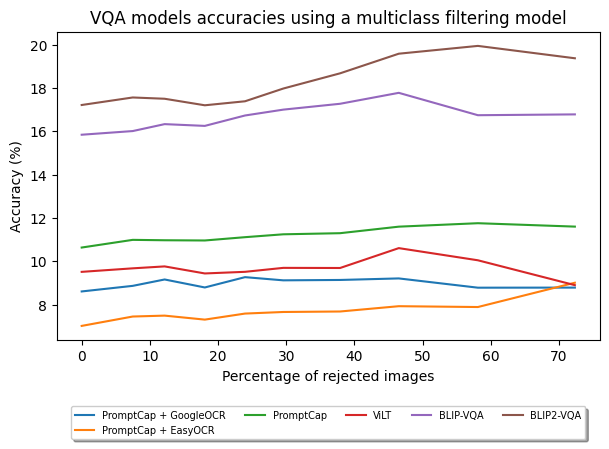

In [22]:
df = df[df["acc"] != 100.]

plt.figure(figsize=(7,4))
for typ in get_model_types(model_output_data)[:-1]:
    try:
        typ = map_type[typ]
    except:
        typ = typ
    data = df[df["model_type"] == typ].sort_values('p_imgs_rej')

    plt.plot(data["p_imgs_rej"].tolist(),
            data["acc"].tolist(), label=typ)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=5, fontsize=7)
    plt.xlabel("Percentage of rejected images")
    plt.ylabel("Accuracy (%)")
plt.title("VQA models accuracies using a multiclass filtering model")
plt.show()

In [23]:
def calculate_df(model):
    cdata = {"model_type": [],
                      "acc": [],
                   "acc_w_blur_model": []
            }
                #"acc_imprv" : []}

    thr = 0.1
    filt_data = get_clear_images(model_output_data, (model, device, thr), multiclass=multiclass)

    for typ in get_model_types(model_output_data)[:-1]:
        res = evaluate_acc_promptcap(model_output_data, typ)
        res_filt = evaluate_acc_promptcap(filt_data, typ)
        try:
            model_type = map_type[typ]
        except:
            model_type = typ
        acc = (sum(res) / len(res)) * 100
        accwflaw = (sum(res_filt) / len(res_filt)) * 100
        cdata["model_type"].append(model_type)
        cdata["acc"].append(acc)
        cdata["acc_w_blur_model"].append(accwflaw)
        #cdata["acc_imprv"].append(accwflaw - acc)
        
    return pd.DataFrame.from_dict(cdata)

Accuries comparison

In [24]:
df_c = calculate_df(model)
df_c

Finshed Percent: [##############------] 67% 

,model_type,acc,acc_w_blur_model
0,PromptCap + GoogleOCR,8.606174,8.783784
1,PromptCap + EasyOCR,7.015903,9.009009
2,PromptCap,10.632990,11.599099
3,ViLT,9.510446,8.896396
4,BLIP-VQA,15.840349,16.779279
5,BLIP2-VQA,17.212348,19.369369


## Models improvement

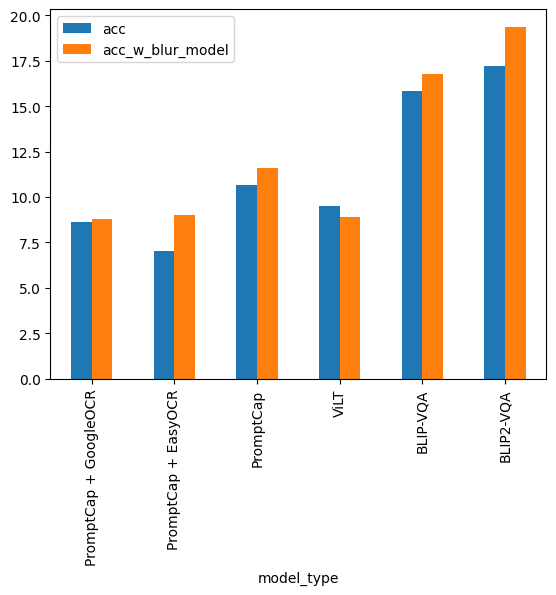

In [25]:
# importing package
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# plot data in stack manner of bar type
df_c.plot(x='model_type', kind='bar', stacked=False, title='')
plt.show()


In [26]:
# Average model improvement across all models
#mean = (df_c["acc_w_blur_model"].mean() + df_c["acc"].mean()) / 2
#avg_imp = (df_c["acc_imprv"].mean() / mean) * 100
#avg_imp

In [27]:
model_classes = ["BLR", "FRM", "MC"]
     
c = []
for mc in model_classes:
    # Load and prepare filtering model
    num_classes = 1 if mc in ["BLR", "FRM"] else 4
    multiclass = True if num_classes > 1 else False
    model_path = f'../outputs/best_{mc}_convnext.pth'
    model = initialize_model(model_path, num_classes)
    model_params = (model, device)
    thr = 0.1
    
    # Filter data
    filt_data = get_clear_images(model_output_data, (model, device, thr), multiclass=multiclass)
    # Create df with results
    df_c = calculate_df(model)

    vqa_model_acc_w_improv = ((df_c["acc_w_blur_model"] - df_c["acc"]) / (df_c["acc"])) * 100
    
    df_c["model_class"] = mc
    df_c["vqa_model_acc_w_improv"] = vqa_model_acc_w_improv
    df_c.set_index('model_class', inplace=True)
    c.append(df_c)
    
df_f = pd.concat(c)

Finshed Percent: [##############------] 67% 

/tmp/ipykernel_6270/1578488093.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(outputs.data).cpu().detach().numpy()[0][0] # value of class0 (clear)


Finshed Percent: [##################--] 91% 

In [28]:
#df_m = pd.DataFrame.from_dict(df_f)
#df_m.set_index('model_class', inplace=True)
#df_m.plot(x='model_type', kind='bar', stacked=False, title='')
#plt.show()
#df_m

## Models accuracy using Vision Language Models with context

Can a visual language model (BLIP2-VQA) 

In [29]:
res_blip2 = evaluate_acc_promptcap(model_output_data, "BLIP2-VQA")
res_blip2_ctx = evaluate_acc_promptcap(filt_data, "BLIP2-CTX-VQA")

acc_blip2 = (sum(res_blip2) / len(res_blip2)) * 100
acc_blip2_ctx = (sum(res_blip2_ctx) / len(res_blip2_ctx)) * 100

df_f.loc["VQA-CTX", "model_type"] = "BLIP2-VQA"
df_f.loc["VQA-CTX", "acc"] = acc_blip2
df_f.loc["VQA-CTX", "acc_w_blur_model"] = acc_blip2_ctx # BLIP2-CTX-VQA acc
df_f.loc["VQA-CTX", "vqa_model_acc_w_improv"] = ((acc_blip2_ctx - acc_blip2) / acc_blip2) * 100
df_f

Finshed Percent: [##################--] 91% 

,model_type,acc,acc_w_blur_model,vqa_model_acc_w_improv
model_class,,,,
BLR,PromptCap + GoogleOCR,8.606174,9.869976,14.684834
BLR,PromptCap + EasyOCR,7.015903,8.628842,22.989756
BLR,PromptCap,10.632990,11.524823,8.387409
BLR,ViLT,9.510446,9.338061,-1.812580
BLR,BLIP-VQA,15.840349,16.962175,7.082077
BLR,BLIP2-VQA,17.212348,17.907801,4.040433
FRM,PromptCap + GoogleOCR,8.606174,8.783784,2.063749
FRM,PromptCap + EasyOCR,7.015903,9.009009,28.408408
FRM,PromptCap,10.632990,11.599099,9.085955


/tmp/ipykernel_6270/1205325008.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  means = df_f.groupby("model_class").mean()["vqa_model_acc_w_improv"].to_numpy()
/tmp/ipykernel_6270/1205325008.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  std = df_f.groupby("model_class").std()["vqa_model_acc_w_improv"].to_numpy()
/tmp/ipykernel_6270/1205325008.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


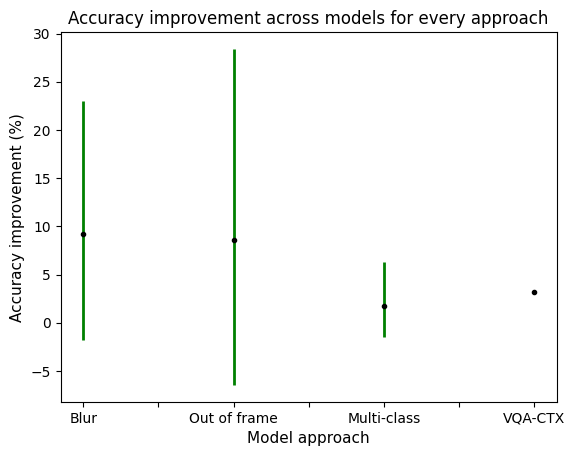

In [30]:
import matplotlib.pyplot as plt
import numpy as np

mins = df_f.groupby("model_class").min()["vqa_model_acc_w_improv"].to_numpy()
maxes = df_f.groupby("model_class").max()["vqa_model_acc_w_improv"].to_numpy()
means = df_f.groupby("model_class").mean()["vqa_model_acc_w_improv"].to_numpy()
std = df_f.groupby("model_class").std()["vqa_model_acc_w_improv"].to_numpy()

# create stacked errorbars:
fig, ax = plt.subplots()
#ax.errorbar(np.arange(len(mins)), means, std, fmt='ok', lw=3)
ax.errorbar(np.arange(len(mins)), means, [means - mins, maxes - means],
             fmt='.k', ecolor='green', lw=2)
ax.set_title("Accuracy improvement across models for every approach")

labels = ['' for item in ax.get_xticklabels()]
labels[1] = "Blur"
labels[3] = "Out of frame"
labels[5] = "Multi-class"
labels[7] = "VQA-CTX"

ax.set_xticklabels(labels)
ax.set_xlabel('Model approach', fontsize=11)
ax.set_ylabel('Accuracy improvement (%)', fontsize=11)
plt.show()